Dahlin controller
=================

︠We will replicate the controller output in figure 17.11a

In [77]:
import sympy
sympy.init_printing()

Discretise the system
--------------------------------

We need to find the corresponding z transform of the hold element and the system. Since $H=1/s(1 - e^{-Ts})$, we can find $F=G/s$, from there $f(t)$ and then work out the $z$ transform

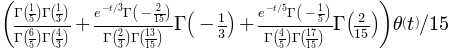

In [139]:
s, t = sympy.symbols('s, t')
Gs = 1/(15*s**2 + 8*s + 1)
f = sympy.inverse_laplace_transform(Gs/s, s, t).simplify()
f

In [140]:
z, q = sympy.symbols('z, q')

Now the sampling rate

In [141]:
T = 1

We can see that $f(t)$ is the sum of 1 and two exponentials. It is easy to determine the corresponding z transforms from the table

In [65]:
def expz(a):
    b = sympy.exp(-a*T)
    return 1/(1 - b*z**-1)

In [66]:
Fz = -5/2*expz(1/5)  + 3/2*expz(1/3) + 1/(1 - z**-1)

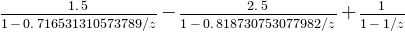

In [67]:
Fz

Let's see if we did that right

In [131]:
def discretecoeffs(Gz, N):
    Gq = Gz.subs({z: q**-1})
    poly = sympy.poly(sympy.series(Gq, q, 0, n=N).removeO(), q)
    return list(reversed(poly.all_coeffs()))

def plotdiscrete(Gz, N):
    times, values = zip(*[(T*power, v) for power, v in enumerate(discretecoeffs(Gz, N))])
    plt.plot(times, values, '.')

In [132]:
import matplotlib.pyplot as plt
%matplotlib inline

In [133]:
import numpy

In [157]:
ts = numpy.linspace(0, 10)

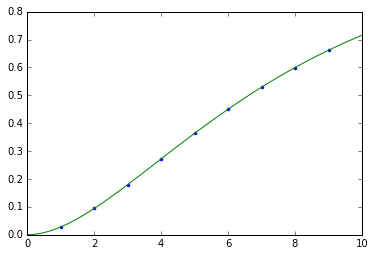

In [135]:
plotdiscrete(Fz, 10)
plt.plot(ts, [sympy.N(f.subs(t, ti+0.001)) for ti in ts])

Here is the transform of the system and the hold element

In [107]:
HG_z = Fz*(1 - z**-1)

Dahlin Controller
-----------------

The desired closed loop response is first order

In [108]:
theta = 0 # system dead time 
lam = 1 # Dahlin's lambda
h = theta # Dahlin's h
T = 1 # Sampling interval

First order response in eq 17-63

In [109]:
N = theta/T
A = sympy.exp(-T/lam)
yclz = (1 - A)*z**(-N-1)/(1 - A*z**-1)

In [120]:
K = (1/HG_z*yclz/(1 - yclz)).simplify()

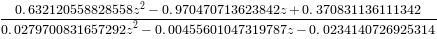

In [111]:
K

In [124]:
#K = 0.632/(1 - z*-1) * (1 - 1.5353*z**-1 + 0.5866*z**-2)/(0.028 + 0.0234*z**-1)

We will model the control response to a unit step in reference signal

In [125]:
rz = 1/(1 - z**-1) # unit step in z

Now we can calculate the z-domain version of the controller output

In [126]:
uz = K/(1 + K*HG_z)*rz

In [152]:
N = 10

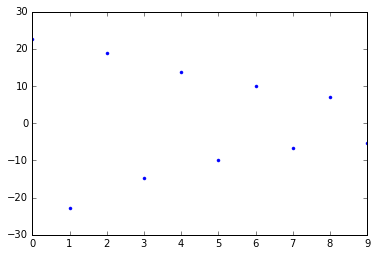

In [153]:
plotdiscrete(uz, N)

Continuous response
-------------------

By design the controlled variable follows an exponential at the sampling points.

In [176]:
yz = K*HG_z/(1 + K*HG_z)*rz

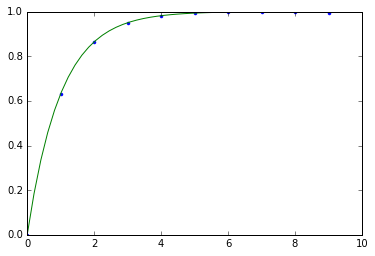

In [177]:
plotdiscrete(yz, N)
plt.plot(ts, 1 - numpy.exp(-ts))

But what does it really look like between data points? First, let's construct the response of the system to a single sampling time length pulse input

In [178]:
p = f - f.subs(t, t-T)

Note that there is a slight issue with finding the value of this function at zero, so we avoid that point in plotting

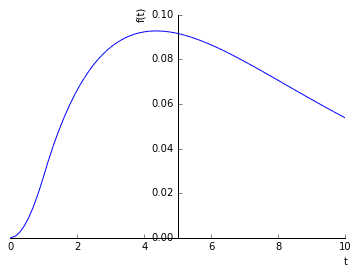

In [180]:
sympy.plot(p, (t, 0.001, 10))

Let's get the values of the controller output as a list:

In [182]:
u = discretecoeffs(uz, N)

Now, we calculate the output of the system as the sum of the various pulse inputs.

In [184]:
plots = []
yt = numpy.zeros_like(ts)
for i in range(0, N):
    yt += [float(sympy.N(u[i]*p.subs(t, ti-i + 0.01))) for ti in ts]

Finally, we present the discrete system response, the designed response and the analytical continuous response on the same graph.

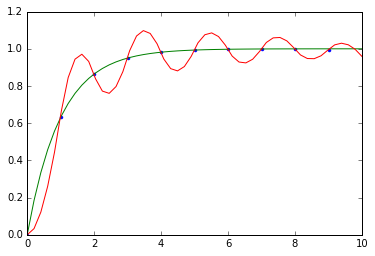

In [185]:
plotdiscrete(yz, 10)
plt.plot(ts, 1 - numpy.exp(-ts))
plt.plot(ts, yt)